In [4]:
# Import necessary libraries
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
import os
import zipfile

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

In [5]:
# Brief description of the problem and data
"""
The goal of this project is to create a Generative Adversarial Network (GAN) that generates images in the style of Claude Monet.
The dataset consists of Monet's paintings, with images sized at 256x256 pixels and RGB color channels.
We aim to generate between 7,000 to 10,000 Monet-style images, which will be evaluated using the MiFID metric for quality.
"""

"\nThe goal of this project is to create a Generative Adversarial Network (GAN) that generates images in the style of Claude Monet.\nThe dataset consists of Monet's paintings, with images sized at 256x256 pixels and RGB color channels.\nWe aim to generate between 7,000 to 10,000 Monet-style images, which will be evaluated using the MiFID metric for quality.\n"

Number of Monet images: 300


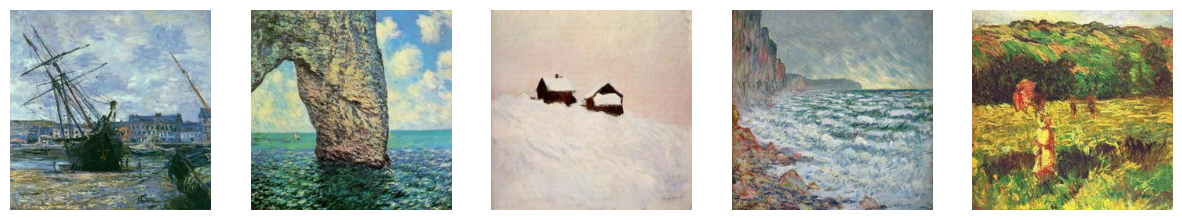

In [7]:
# Define file paths

# os.listdir('/kaggle/input/gan-getting-started')
# ['monet_jpg', 'photo_tfrec', 'photo_jpg', 'monet_tfrec']

# DATA_PATH = '/kaggle/input/gan-getting-started/monet_jpg'
# OUTPUT_PATH = '/kaggle/input/gan-getting-started/photo_jpg'
# ZIP_PATH = '/kaggle/working/images.zip'

DATA_PATH = 'monet_jpg'
OUTPUT_PATH = 'photo_jpg'
ZIP_PATH = 'images.zip'

# Load and explore the dataset
monet_images = [os.path.join(DATA_PATH, f) for f in os.listdir(DATA_PATH) if f.endswith('.jpg')]
print(f"Number of Monet images: {len(monet_images)}")

# Display a few sample images
def display_images(images, n=5):
    plt.figure(figsize=(15, 5))
    for i in range(n):
        img = plt.imread(images[i])
        plt.subplot(1, n, i+1)
        plt.imshow(img)
        plt.axis('off')
    plt.show()

display_images(monet_images)

In [11]:
# Define the GAN components: generator and discriminator
def build_generator():
    model = models.Sequential()
    model.add(layers.Dense(128, input_shape=(100,)))  # Reduced units
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dense(256))  # Reduced units
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dense(256 * 256 * 3, activation='tanh'))  # Same output size
    model.add(layers.Reshape((256, 256, 3)))
    return model

def build_discriminator():
    model = models.Sequential()
    model.add(layers.Flatten(input_shape=(256, 256, 3)))
    model.add(layers.Dense(256))  # Reduced units
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dense(128))  # Reduced units
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dense(1, activation='sigmoid'))  # Binary output
    return model


In [12]:
# Compile the GAN
generator = build_generator()
discriminator = build_discriminator()
discriminator.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Combine generator and discriminator into a GAN
discriminator.trainable = False
gan_input = layers.Input(shape=(100,))
generated_image = generator(gan_input)
gan_output = discriminator(generated_image)
gan = models.Model(gan_input, gan_output)
gan.compile(loss='binary_crossentropy', optimizer='adam')

In [15]:
import time

# Training the GAN
def train_gan(epochs, batch_size):
    total_start_time = time.time()  # Start time for total training
    for epoch in range(epochs):
        epoch_start_time = time.time()  # Start time for the current epoch
        for _ in range(batch_size):
            # Generate random noise
            noise = np.random.normal(0, 1, size=[batch_size, 100])
            generated_images = generator.predict(noise)

            # Load a batch of real images from dataset
            idx = np.random.randint(0, len(monet_images), batch_size)
            real_images = np.array([plt.imread(monet_images[i]) for i in idx])
            real_images = (real_images - 127.5) / 127.5  # Normalize to [-1, 1]

            # Train the discriminator
            d_loss_real = discriminator.train_on_batch(real_images, np.ones((batch_size, 1)))
            d_loss_fake = discriminator.train_on_batch(generated_images, np.zeros((batch_size, 1)))
            d_loss = (0.5 * np.add(d_loss_real, d_loss_fake)).reshape(-1, 1)

            # Train the generator
            noise = np.random.normal(0, 1, size=[batch_size, 100])
            g_loss = gan.train_on_batch(noise, np.ones((batch_size, 1)))

        # Time taken for the current epoch
        epoch_time = time.time() - epoch_start_time
        print(f'Epoch {epoch + 1}/{epochs}, '
              f'Discriminator Loss: {d_loss[0][0]:.4f}, '
              f'Generator Loss: {g_loss:.4f}, '
              f'Time for this epoch: {epoch_time:.2f} seconds')

    # Total time taken for training
    total_time = time.time() - total_start_time
    print(f'Total training time: {total_time:.2f} seconds')

# Train the GAN (specify epochs and batch size)
train_gan(epochs=10, batch_size=32)

Epoch 1/10, Discriminator Loss: 20.0164, Generator Loss: 165.7011, Time for this epoch: 48.87 seconds
Epoch 2/10, Discriminator Loss: 3.6509, Generator Loss: 157.8787, Time for this epoch: 46.42 seconds
Epoch 3/10, Discriminator Loss: 4.4629, Generator Loss: 144.9584, Time for this epoch: 48.07 seconds
Epoch 4/10, Discriminator Loss: 8.9848, Generator Loss: 99.5352, Time for this epoch: 50.51 seconds
Epoch 5/10, Discriminator Loss: 1.8670, Generator Loss: 86.6157, Time for this epoch: 44.43 seconds
Epoch 6/10, Discriminator Loss: 3.9208, Generator Loss: 207.8123, Time for this epoch: 42.01 seconds
Epoch 7/10, Discriminator Loss: 0.3552, Generator Loss: 44.1839, Time for this epoch: 49.05 seconds
Epoch 8/10, Discriminator Loss: 1.5322, Generator Loss: 54.3975, Time for this epoch: 51.20 seconds
Epoch 9/10, Discriminator Loss: 8.6243, Generator Loss: 49.0026, Time for this epoch: 45.15 seconds
Epoch 10/10, Discriminator Loss: 1.7493, Generator Loss: 35.8189, Time for this epoch: 47.93 se

In [17]:
# Generate and save Monet-style images in batches
def generate_and_save_images(num_images, batch_size, path):
    os.makedirs(path, exist_ok=True)

    for batch_start in range(0, num_images, batch_size):
        # Determine the number of images to generate in this batch
        current_batch_size = min(batch_size, num_images - batch_start)
        
        # Generate random noise
        noise = np.random.normal(0, 1, size=[current_batch_size, 100])
        generated_images = generator.predict(noise)

        # Save generated images
        for i in range(generated_images.shape[0]):
            img = (generated_images[i] * 127.5 + 127.5).astype(np.uint8)
            plt.imsave(os.path.join(path, f'image_{batch_start + i}.jpg'), img)

        # Print progress every 100 images
        print(f'Saved images from {batch_start + 1} to {batch_start + current_batch_size}.')

NUM_IMAGES = 7_000
BATCH_SIZE = 500  # Define your batch size

generate_and_save_images(NUM_IMAGES, BATCH_SIZE, OUTPUT_PATH)

# Final progress message
print(f'All {NUM_IMAGES} images saved successfully.')

Saved images from 1 to 100.
Saved images from 101 to 200.
Saved images from 201 to 300.
Saved images from 301 to 400.
Saved images from 401 to 500.
Saved images from 501 to 600.
Saved images from 601 to 700.
Saved images from 701 to 800.
Saved images from 801 to 900.
Saved images from 901 to 1000.
Saved images from 1001 to 1100.
Saved images from 1101 to 1200.
Saved images from 1201 to 1300.
Saved images from 1301 to 1400.
Saved images from 1401 to 1500.
Saved images from 1501 to 1600.
Saved images from 1601 to 1700.
Saved images from 1701 to 1800.
Saved images from 1801 to 1900.
Saved images from 1901 to 2000.
Saved images from 2001 to 2100.
Saved images from 2101 to 2200.
Saved images from 2201 to 2300.
Saved images from 2301 to 2400.
Saved images from 2401 to 2500.
Saved images from 2501 to 2600.
Saved images from 2601 to 2700.
Saved images from 2701 to 2800.
Saved images from 2801 to 2900.
Saved images from 2901 to 3000.
Saved images from 3001 to 3100.
Saved images from 3101 to 320

In [18]:
# Zip the images for submission
with zipfile.ZipFile(ZIP_PATH, 'w') as zipf:
    for root, _, files in os.walk(OUTPUT_PATH):
        for file in files:
            zipf.write(os.path.join(root, file), arcname=file)

print("Generated images saved and zipped successfully.")

Generated images saved and zipped successfully.
